In [1]:
%reset -f
import sys
sys.path.insert(0, "..")
from wavhandler import *
from configs import DatasetConfiguration
from utils_train import *
from configs import *
import numpy as np
import math
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, classification_report, make_scorer, log_loss
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
import os
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Input
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Activation, GlobalAveragePooling2D
import seaborn as sb
import deepdish as dd

seed = 42
np.random.seed(seed=seed)

splitting = 'custom'
data_setting = 'rawflt'
model_setting = 'dl4tsc_inc'
nb_classes = 2
# clean = True

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/kalfasyan/anaconda3/envs/wbtf/lib/pyt

### data collecting

In [2]:
train = pd.read_csv(f"{TEMP_DATADIR}/df_train_{data_setting}_{splitting}.csv", index_col=False)
X_train = train.x.tolist()
y_train = train.y.tolist()

In [3]:
val = pd.read_csv(f"{TEMP_DATADIR}/df_val_{data_setting}_{splitting}.csv", index_col=False)
X_val = val.x.tolist()
y_val = val.y.tolist()

In [4]:
test = pd.read_csv(f"{TEMP_DATADIR}/df_test_{data_setting}_{splitting}.csv", index_col=False)
X_test = test.x.tolist()
y_test = test.y.tolist()

In [5]:
print(f"train: \n{pd.Series(y_train).value_counts()}\n")
print(f"val: \n{pd.Series(y_val).value_counts()}\n")
print(f"test: \n{pd.Series(y_test).value_counts()}")

train: 
0    13753
1    13650
dtype: int64

val: 
0    4607
1    4528
dtype: int64

test: 
1    12337
0     3139
dtype: int64


### training

In [6]:
traincf = TrainConfiguration(nb_classes=nb_classes, setting=data_setting,model_name=f"Flies_{data_setting}_{model_setting}_{splitting}", monitor='val_acc')

In [7]:
modelconf = ModelConfiguration(model_setting=model_setting, data_setting=data_setting, nb_classes=nb_classes)
model = modelconf.config

base_output = model.layers[-2].output
new_output = Dense(1, activation=None)(base_output)
new_output2 = Activation('sigmoid')(new_output)
model = Model(inputs=model.inputs, outputs=new_output2)

print("Last 5 layers:")
for i in model.layers[-5:]:
    print(i.name)

############ INPUT SHAPE:(5000, 1)
/home/kalfasyan/projects/wingbeat_frequencies/temp_data/
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Last 5 layers:
batch_normalization_17
activation_18
global_average_pooling1d_1
dense_1
activation_19


In [9]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 5000, 1)]    0                                            
__________________________________________________________________________________________________
max_pooling1d_7 (MaxPooling1D)  (None, 5000, 1)      0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_36 (Conv1D)              (None, 5000, 32)     416         input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_37 (Conv1D)              (None, 5000, 32)     192         input_2[0][0]                    
____________________________________________________________________________________________

In [10]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [11]:
from sklearn.utils import class_weight
weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = {i : weights[i] for i in range(nb_classes)}
print(class_weights)

{0: 0.9962553624663709, 1: 1.0037728937728938}


In [12]:
h = model.fit(train_generator(X_train, y_train, 
                                    batch_size=traincf.batch_size,
                                    target_names=np.unique(y_test).tolist(),
                                    setting=traincf.setting,
                                     preprocessing_train_stats='', binary_labels=True),
                    steps_per_epoch = int(math.ceil(float(len(X_train)) / float(traincf.batch_size))),
                    epochs = traincf.epochs,
                    validation_data = valid_generator(X_val, y_val,
                                                        batch_size=traincf.batch_size,
                                                        target_names=np.unique(y_test).tolist(),
                                                        setting=traincf.setting,
                                                         preprocessing_train_stats='', binary_labels=True),
                    validation_steps=int(math.ceil(float(len(X_val))/float(traincf.batch_size))),
                    callbacks=traincf.callbacks_list,
             class_weight=class_weights)

Epoch 1/100
856/857 [============================>.] - ETA: 0s - loss: 0.3552 - acc: 0.8449
Epoch 00001: val_acc improved from -inf to 0.81029, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/Flies_rawflt_dl4tsc_inc_custom.h5
857/857 [==============================] - 245s 286ms/step - loss: 0.3562 - acc: 0.8447 - val_loss: 0.4652 - val_acc: 0.8103
Epoch 2/100
856/857 [============================>.] - ETA: 0s - loss: 0.2447 - acc: 0.9033
Epoch 00002: val_acc did not improve from 0.81029
857/857 [==============================] - 242s 282ms/step - loss: 0.2459 - acc: 0.9031 - val_loss: 3.4187 - val_acc: 0.5633
Epoch 3/100
856/857 [============================>.] - ETA: 0s - loss: 0.1816 - acc: 0.9326
Epoch 00003: val_acc improved from 0.81029 to 0.92414, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/Flies_rawflt_dl4tsc_inc_custom.h5
857/857 [==============================] - 243s 283ms/step - loss: 0.1827 - acc: 0.9324 - val_loss: 0.201

In [21]:
pred = model.predict_generator(valid_generator(X_test, y_test,
                                    batch_size=traincf.batch_size,
                                    target_names=np.unique(y_test).tolist(),
                                    setting=traincf.setting,
                                  preprocessing_train_stats='', binary=True),
                              steps=int(math.ceil(float(len(X_test))/float(traincf.batch_size))))

In [37]:
y_pred = np.where(pred < 0.5, 0 , 1)

In [38]:
from sklearn.metrics import balanced_accuracy_score, confusion_matrix

balanced_accuracy_score(y_true=y_test, y_pred=y_pred)

0.8428012916335998

Text(33.0, 0.5, 'actual')

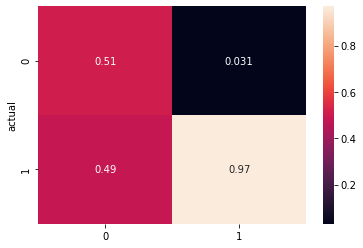

In [39]:
import seaborn as sns

cm = confusion_matrix(y_true=y_test, y_pred=y_pred)
cm = cm.astype(np.float) / cm.astype(np.float).sum(axis=0)

sns.heatmap(cm, annot=True, fmt='.2g')
plt.ylabel('actual')

#### 0=melanogaster, 1=suzukii, 2=zaprionus

In [25]:
y_pred = np.argmax(pred, axis=1)

sub = pd.concat([pd.Series(y_test), pd.Series(X_test)], axis=1)
sub['preds'] = y_pred
sub.columns = ['labels','fnames','preds']
sub['datestr'] = get_wingbeat_dates(sub.fnames)[2]

In [26]:
sub.to_csv(f'{TEMP_DATADIR}/df_{model_setting}_{data_setting}_{splitting}.csv', index=False)